In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import scipy.stats as sps
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


In [2]:
data=pd.read_excel("raw_data.xlsx")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              39998 non-null  float64
 1   total_pageviews  39998 non-null  float64
 2   edu              39998 non-null  float64
 3   edu_ages         39998 non-null  float64
 4   user_level       39998 non-null  float64
 5   industry         39997 non-null  float64
 6   value_level      39999 non-null  int64  
 7   act_level        39998 non-null  float64
 8   sex              39998 non-null  float64
 9   blue_money       39999 non-null  int64  
 10  red_money        39998 non-null  float64
 11  work_hours       39999 non-null  int64  
 12  region           39997 non-null  float64
 13  response         39999 non-null  int64  
dtypes: float64(10), int64(4)
memory usage: 4.3 MB


### Filling missing value

Technically speaking, the method will lead to data leakage, which means the training dataset includes the information of the testing dataset that is about to predict, because this approach uses the information of the entire dataset to fill the missing values.

But, as we have 1 to 2 missing values for each column, only a fraction of the entire dataset, its detriment impact can be ignored.

In [3]:
# find columns with meaning values
selector=data.isnull().any(axis=0)
data.loc[:,selector].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              39998 non-null  float64
 1   total_pageviews  39998 non-null  float64
 2   edu              39998 non-null  float64
 3   edu_ages         39998 non-null  float64
 4   user_level       39998 non-null  float64
 5   industry         39997 non-null  float64
 6   act_level        39998 non-null  float64
 7   sex              39998 non-null  float64
 8   red_money        39998 non-null  float64
 9   region           39997 non-null  float64
dtypes: float64(10)
memory usage: 3.1 MB


Based on the common sense, `edu` (education level) should be highly related to `edu_ages` (education age). So I will fill nan value of `edu` and `edu_age` with the mode of their category level. The missing values of the other columns will be filled with either median or mode.

In [4]:
# build the edu_ages to edu mapping rule
edu_rule=data.groupby(["edu"])["edu_ages"].agg(pd.Series.mode)
data.loc[data.edu.isnull(),"edu"]=data.loc[data.edu.isnull(),"edu_ages"].map(edu_rule)

In [5]:
# build the edu to edu_age mapping rule
edu_age_rule=data.groupby(["edu_ages"])["edu"].agg(pd.Series.mode)
data.loc[data.edu_ages.isnull(),"edu_ages"]=data.loc[data.edu_ages.isnull(),"edu"].map(edu_age_rule)

In [6]:
filling_rule={"age":data["age"].median(),
             "total_pageviews":data["total_pageviews"].median(),
             "user_level":data["user_level"].median(),
              "industry":data["industry"].mode()[0],
             "act_level":data["act_level"].median(),
             "sex":data["sex"].mode()[0],
             "red_money":data["red_money"].median(),
              "region":data["region"].mode()[0]
             }

In [7]:
data_clean=data.fillna(filling_rule)

### change data types

In [8]:
data_clean[["industry","region"]]=data_clean[["industry","region"]].astype("str")
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              39999 non-null  float64
 1   total_pageviews  39999 non-null  float64
 2   edu              39999 non-null  float64
 3   edu_ages         39999 non-null  float64
 4   user_level       39999 non-null  float64
 5   industry         39999 non-null  object 
 6   value_level      39999 non-null  int64  
 7   act_level        39999 non-null  float64
 8   sex              39999 non-null  float64
 9   blue_money       39999 non-null  int64  
 10  red_money        39999 non-null  float64
 11  work_hours       39999 non-null  int64  
 12  region           39999 non-null  object 
 13  response         39999 non-null  int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 4.3+ MB


## Building models to predict customer responses

Instead of sending the campaign ads to all customers, we target only a subset of customers, 50% of customers randomly sampled. 

In [9]:
np.random.seed(1)
campaign_order=np.arange(len(data_clean))
np.random.shuffle(campaign_order)
round1=campaign_order[:int(len(data_clean)/2)]
round2=campaign_order[int(len(data_clean)/2):]

In [10]:
X_1st,X_2nd,y_1st,y_2nd=train_test_split(data_clean.drop(columns=["response"]),data_clean["response"],test_size=0.5, random_state=42)

df_1round=data_clean.iloc[round1,:]

### EDA on 1st round

In [11]:
df_1round.describe()

,age,total_pageviews,edu,edu_ages,user_level,value_level,act_level,sex,blue_money,red_money,work_hours,response
count,19999.000000,1.999900e+04,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,38.687684,1.884309e+05,2.524226,10.055603,2.100155,2.540827,1.222811,0.664133,1103.334267,88.529176,40.511926,0.238562
std,13.704705,1.045582e+05,1.646473,2.566704,1.270858,1.443478,0.630236,0.472304,7597.708589,404.735675,12.380019,0.426215
min,17.000000,1.376900e+04,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.168560e+05,2.000000,9.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.778580e+05,2.000000,10.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.360100e+05,2.000000,12.000000,2.000000,4.000000,1.000000,1.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,10.000000,16.000000,7.000000,6.000000,5.000000,1.000000,99999.000000,4356.000000,99.000000,1.000000


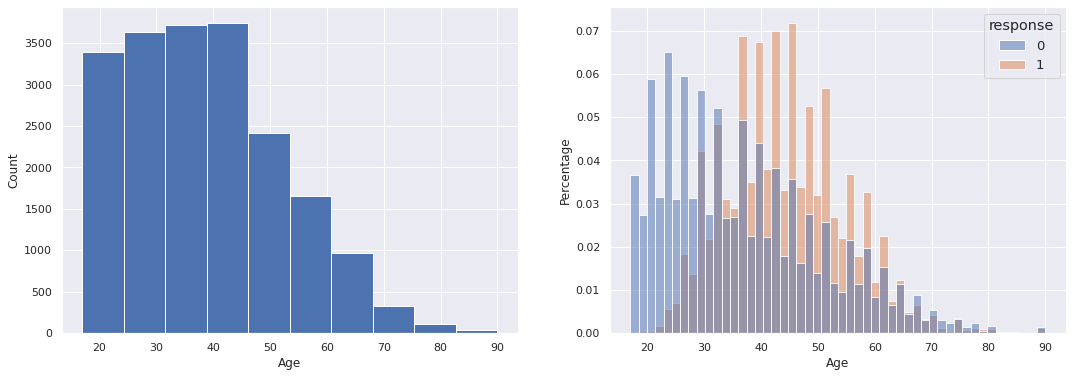

In [12]:
sns.set_theme()
fig,axs=plt.subplots(1,2,figsize=(18,6))
sns.set(font_scale=1.2)
df_1round.age.hist(ax=axs[0])
axs[0].set(xlabel="Age",ylabel="Count")
sns.histplot(x="age",hue="response",data=df_1round,fill=True,ax=axs[1],common_norm=False,stat="probability")
axs[1].set(xlabel="Age",ylabel="Percentage");

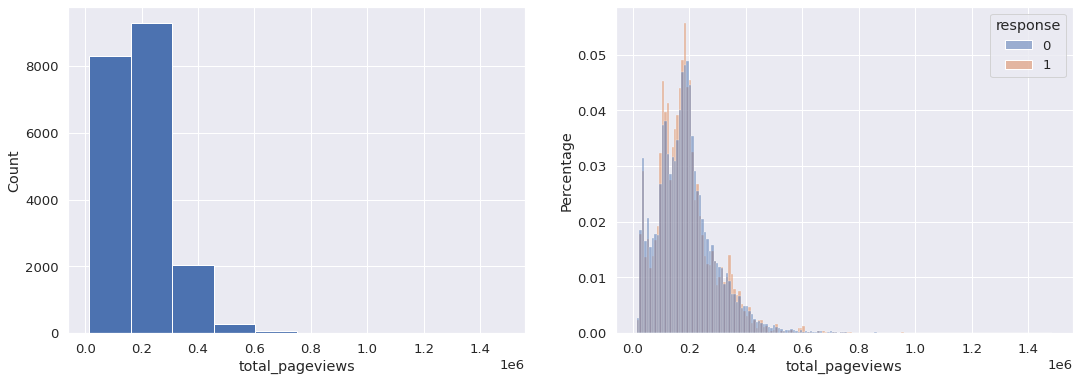

In [13]:
fig,axs=plt.subplots(1,2,figsize=(18,6))
sns.set(font_scale=1.2)
df_1round.total_pageviews.hist(ax=axs[0])
axs[0].set(xlabel="total_pageviews",ylabel="Count")
sns.histplot(x="total_pageviews",hue="response",data=df_1round,fill=True,ax=axs[1],common_norm=False,stat="probability")
axs[1].set(ylabel="Percentage");

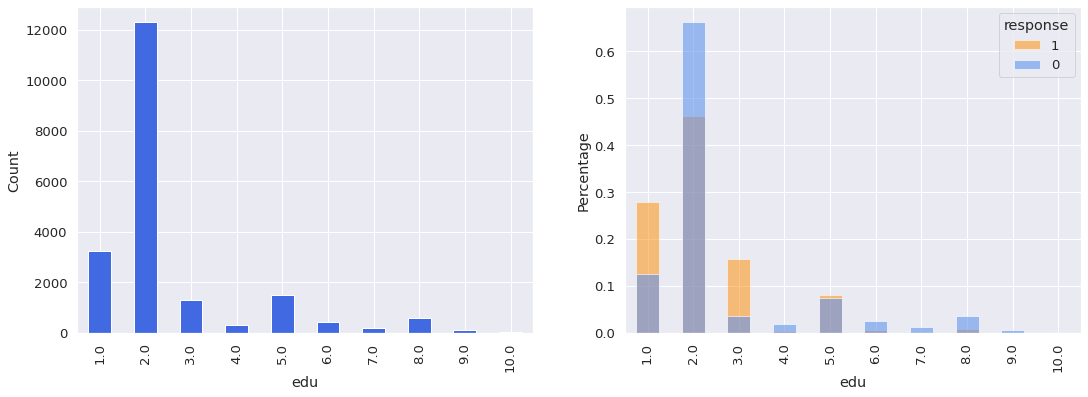

In [14]:
fig,axs=plt.subplots(1,2,figsize=(18,6))
sns.set(font_scale=1.2)
df_1round.edu.value_counts().sort_index().plot(color="royalblue",ax=axs[0],kind="bar")
axs[0].set(xlabel="edu",ylabel="Count")
df_1round.query("response==1").edu.value_counts(normalize=True).sort_index().plot(color="darkorange",ax=axs[1],kind="bar",alpha=0.5,label="1")
df_1round.query("response==0").edu.value_counts(normalize=True).sort_index().plot(color="cornflowerblue",ax=axs[1],kind="bar",alpha=0.6,label="0")
axs[1].set(xlabel="edu",ylabel="Percentage")
axs[1].legend(title="response");

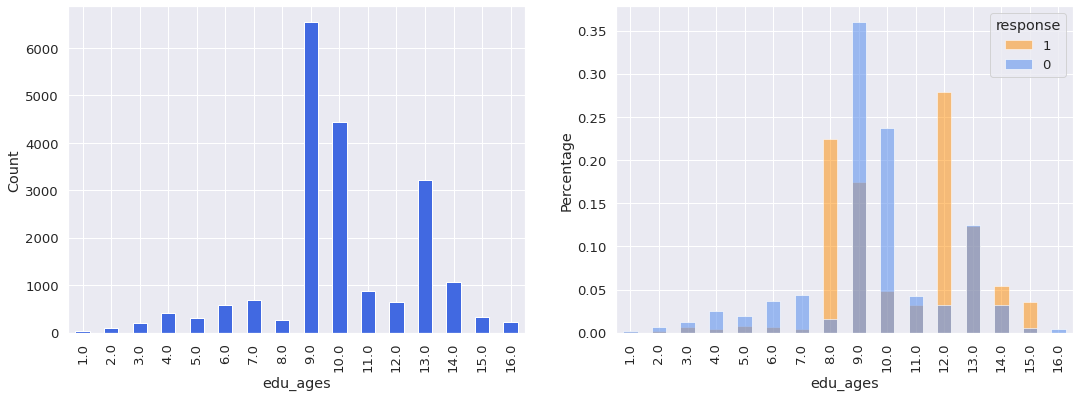

In [15]:
fig,axs=plt.subplots(1,2,figsize=(18,6))
sns.set(font_scale=1.2)
df_1round.edu_ages.value_counts().sort_index().plot(color="royalblue",ax=axs[0],kind="bar")
axs[0].set(xlabel="edu_ages",ylabel="Count")
df_1round.query("response==1").edu_ages.value_counts(normalize=True).sort_index().plot(color="darkorange",ax=axs[1],kind="bar",alpha=0.5,label="1")
df_1round.query("response==0").edu_ages.value_counts(normalize=True).sort_index().plot(color="cornflowerblue",ax=axs[1],kind="bar",alpha=0.6,label="0")
axs[1].set(xlabel="edu_ages",ylabel="Percentage")
axs[1].legend(title="response");

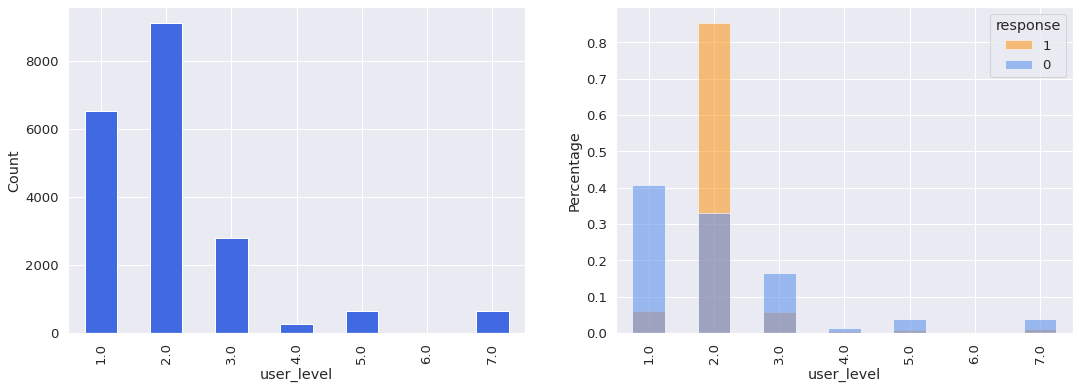

In [16]:
fig,axs=plt.subplots(1,2,figsize=(18,6))
sns.set(font_scale=1.2)
df_1round.user_level.value_counts().sort_index().plot(color="royalblue",ax=axs[0],kind="bar")
axs[0].set(xlabel="user_level",ylabel="Count")
df_1round.query("response==1").user_level.value_counts(normalize=True).sort_index().plot(color="darkorange",ax=axs[1],kind="bar",alpha=0.5,label="1")
df_1round.query("response==0").user_level.value_counts(normalize=True).sort_index().plot(color="cornflowerblue",ax=axs[1],kind="bar",alpha=0.6,label="0")
axs[1].set(xlabel="user_level",ylabel="Percentage")
axs[1].legend(title="response");

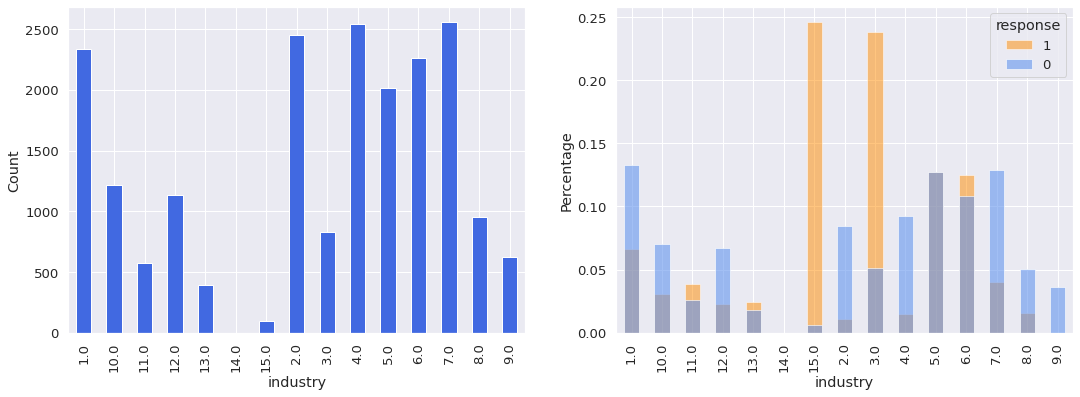

In [17]:
fig,axs=plt.subplots(1,2,figsize=(18,6))
sns.set(font_scale=1.2)
df_1round.industry.value_counts().sort_index().plot(color="royalblue",ax=axs[0],kind="bar")
axs[0].set(xlabel="industry",ylabel="Count")
df_1round.query("response==1").industry.value_counts(normalize=True).sort_index().plot(color="darkorange",ax=axs[1],kind="bar",alpha=0.5,label="1")
df_1round.query("response==0").industry.value_counts(normalize=True).sort_index().plot(color="cornflowerblue",ax=axs[1],kind="bar",alpha=0.6,label="0")
axs[1].set(xlabel="industry",ylabel="Percentage")
axs[1].legend(title="response");

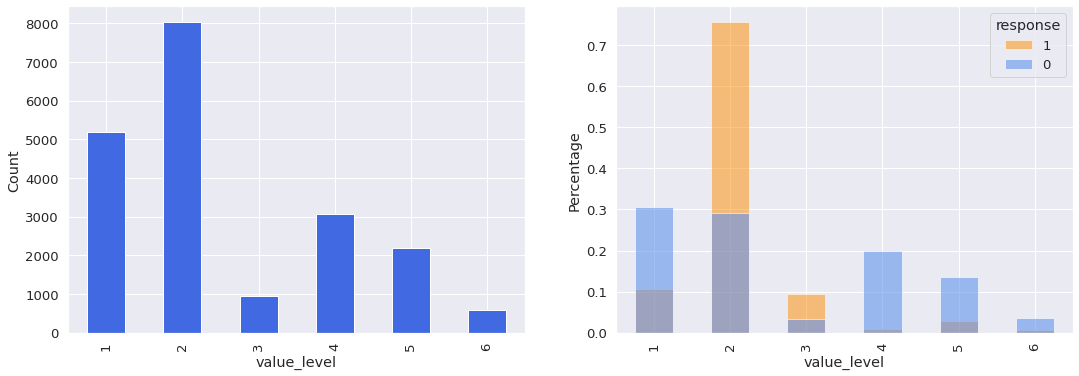

In [18]:
fig,axs=plt.subplots(1,2,figsize=(18,6))
sns.set(font_scale=1.2)
df_1round.value_level.value_counts().sort_index().plot(color="royalblue",ax=axs[0],kind="bar")
axs[0].set(xlabel="value_level",ylabel="Count")
df_1round.query("response==1").value_level.value_counts(normalize=True).sort_index().plot(color="darkorange",ax=axs[1],kind="bar",alpha=0.5,label="1")
df_1round.query("response==0").value_level.value_counts(normalize=True).sort_index().plot(color="cornflowerblue",ax=axs[1],kind="bar",alpha=0.6,label="0")
axs[1].set(xlabel="value_level",ylabel="Percentage")
axs[1].legend(title="response");

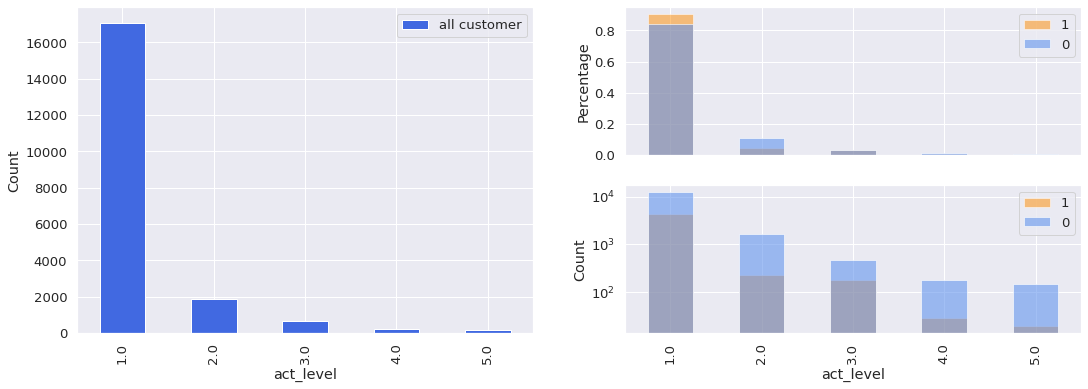

In [19]:
plt.figure(figsize=(18,6))
ax1=plt.subplot2grid((2,2), (0,0), rowspan=2)
ax2=plt.subplot2grid((2,2),(0,1))
ax3=plt.subplot2grid((2,2),(1,1),sharex=ax2)
df_1round.act_level.value_counts().sort_index().plot(color="royalblue",ax=ax1,kind="bar",label="all customer")
ax1.legend()
ax1.set(xlabel="act_level",ylabel="Count")
df_1round.query("response==1").act_level.value_counts(normalize=True).sort_index().plot(color="darkorange",ax=ax2,kind="bar",alpha=0.5,label="1")
df_1round.query("response==0").act_level.value_counts(normalize=True).sort_index().plot(color="cornflowerblue",ax=ax2,kind="bar",alpha=0.6,label="0")
ax2.legend()
ax2.set(ylabel="Percentage")
# sns.histplot(x="blue_money",hue="response",data=df_1round,fill=True,ax=ax2,common_norm=False,stat="probability")
# ax2.set_xlabel("")
df_1round.query("response==1").act_level.value_counts().sort_index().plot(color="darkorange",ax=ax3,kind="bar",alpha=0.5,label="1")
df_1round.query("response==0").act_level.value_counts().sort_index().plot(color="cornflowerblue",ax=ax3,kind="bar",alpha=0.6,label="0")
ax3.set_yscale("log")
ax3.set(xlabel="act_level",ylabel="Count")
ax3.legend();

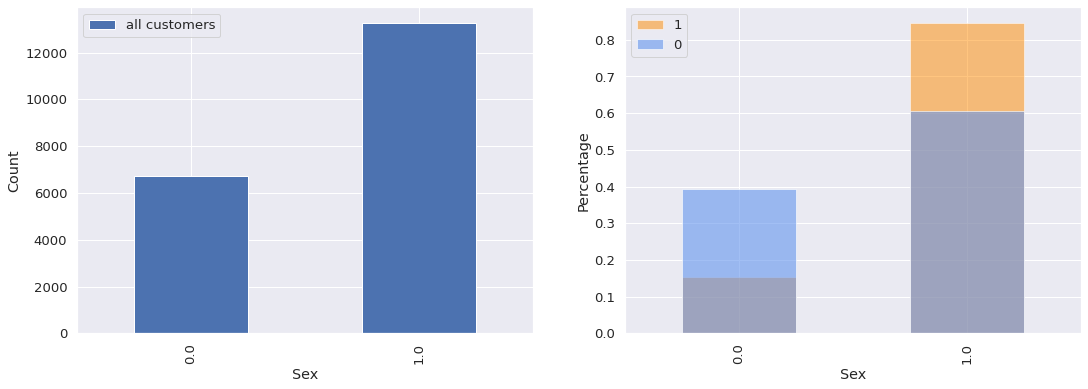

In [20]:
fig,axs=plt.subplots(1,2,figsize=(18,6))
df_1round.sex.value_counts().sort_index().plot(kind="bar",ax=axs[0],label="all customers")
axs[0].set(xlabel="Sex",ylabel="Count")
axs[0].legend()
df_1round.query("response==1")["sex"].value_counts(normalize=True).sort_index().plot(color="darkorange",kind="bar",alpha=0.5,ax=axs[1],label="1")
df_1round.query("response==0")["sex"].value_counts(normalize=True).sort_index().plot(color="cornflowerblue",kind="bar",alpha=0.6,ax=axs[1],label="0")
axs[1].legend()
axs[1].set(xlabel="Sex",ylabel="Percentage");

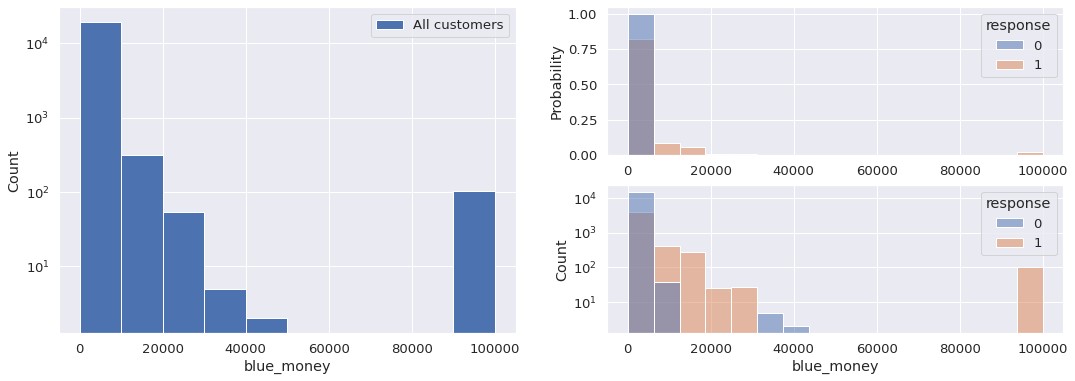

In [21]:
plt.figure(figsize=(18,6))
ax1=plt.subplot2grid((2,2), (0,0), rowspan=2)
ax2=plt.subplot2grid((2,2),(0,1))
ax3=plt.subplot2grid((2,2),(1,1),sharex=ax2)
df_1round.blue_money.hist(ax=ax1,label="All customers")
ax1.set_yscale("log")
ax1.legend()
ax1.set(xlabel="blue_money",ylabel="Count")
sns.histplot(x="blue_money",hue="response",data=df_1round,fill=True,ax=ax2,common_norm=False,stat="probability")
ax2.set_xlabel("")
sns.histplot(x="blue_money",hue="response",data=df_1round,fill=True,ax=ax3,common_norm=False,stat="count")
ax3.set_yscale("log")

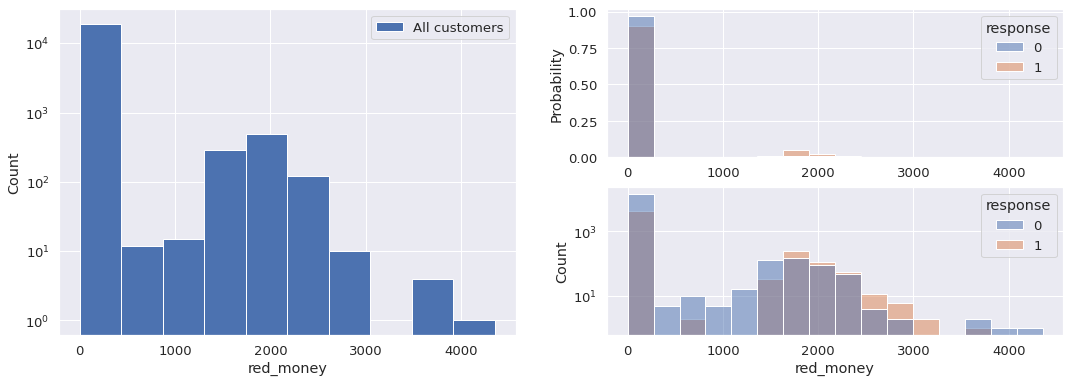

In [22]:
plt.figure(figsize=(18,6))
ax1=plt.subplot2grid((2,2), (0,0), rowspan=2)
ax2=plt.subplot2grid((2,2),(0,1))
ax3=plt.subplot2grid((2,2),(1,1),sharex=ax2)
df_1round.red_money.hist(ax=ax1,label="All customers")
ax1.set_yscale("log")
ax1.legend()
ax1.set(xlabel="red_money",ylabel="Count")
sns.histplot(x="red_money",hue="response",data=df_1round,fill=True,ax=ax2,common_norm=False,stat="probability")
ax2.set_xlabel("")
sns.histplot(x="red_money",hue="response",data=df_1round,fill=True,ax=ax3,common_norm=False,stat="count")
ax3.set_yscale("log")

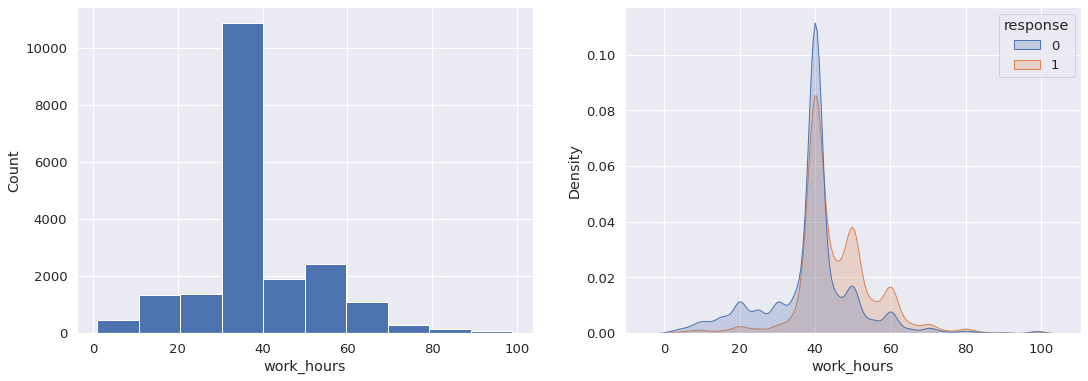

In [23]:
fig,axs=plt.subplots(1,2,figsize=(18,6))
sns.set(font_scale=1.2)
df_1round.work_hours.hist(ax=axs[0])
axs[0].set(xlabel="work_hours",ylabel="Count")
sns.kdeplot(x="work_hours",hue="response",data=df_1round,fill=True,ax=axs[1],common_norm=False);

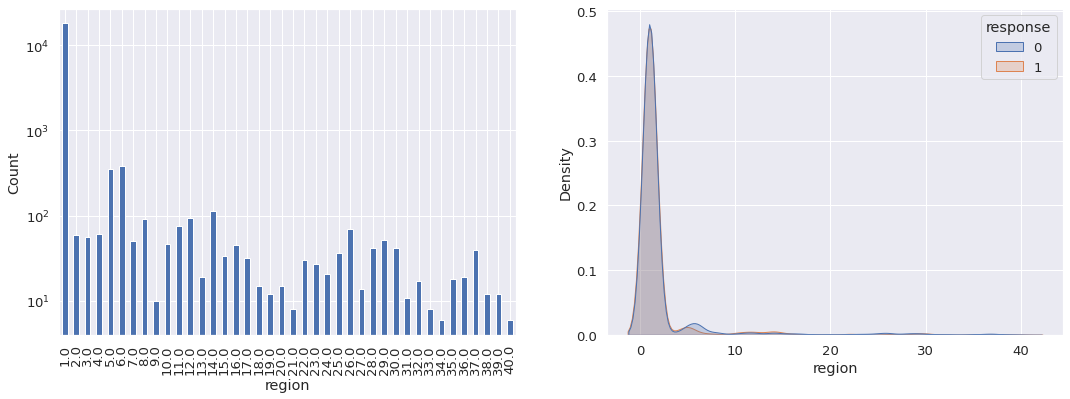

In [24]:
fig,axs=plt.subplots(1,2,figsize=(18,6))
sns.set(font_scale=1.2)
df_1round.region.astype("float").value_counts().sort_index().plot(ax=axs[0],kind="bar")
axs[0].set_yscale("log")
axs[0].set(xlabel="region",ylabel="Count")
sns.kdeplot(x="region",hue="response",data=df_1round.assign(region=df_1round.region.astype("float")),fill=True,ax=axs[1],common_norm=False);

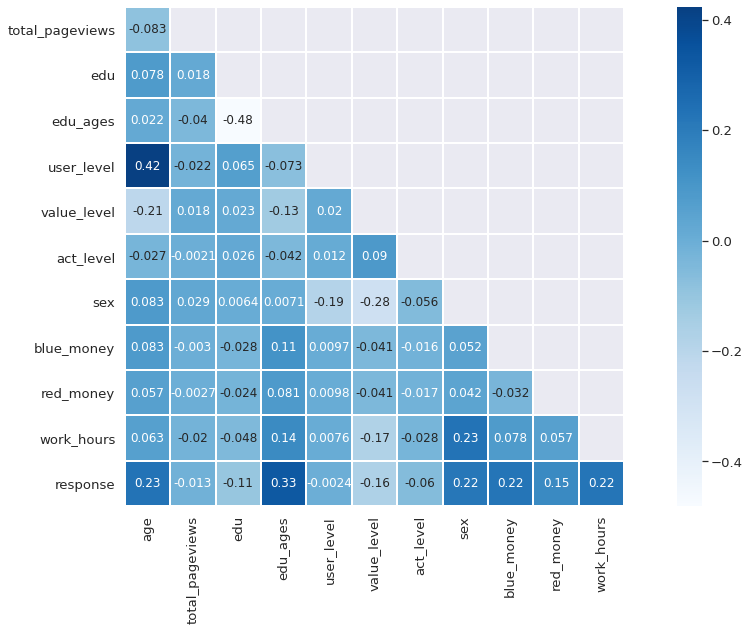

In [25]:
plt.figure(figsize=(15,9))
user_corr=df_1round.corr()
mask=np.triu(np.ones_like(user_corr,dtype=bool))[1:,:-1]
corr=user_corr.iloc[1:,:-1]
sns.heatmap(corr, 
            center=0,
            square=True, 
            linewidths=1,
            cmap="Blues",
           mask=mask,
           annot=True,
           annot_kws={"size": 12});
plt.tight_layout()
plt.savefig("corr.png")

### Feature Engineering

#### Build ratio variables

I will deivide numeric variables by age or work hours to create new variables.

In [26]:
entities=["red_money","total_pageviews","edu","edu_ages","user_level","value_level","act_level","blue_money"]
denoms=["age","work_hours"]
for d in denoms:
    for entity in tqdm(entities):
        data_clean[d+"_"+entity]=data_clean[entity]/data_clean[d]
            
data_clean.info()

100%|██████████| 8/8 [00:00<00:00, 767.70it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         39999 non-null  float64
 1   total_pageviews             39999 non-null  float64
 2   edu                         39999 non-null  float64
 3   edu_ages                    39999 non-null  float64
 4   user_level                  39999 non-null  float64
 5   industry                    39999 non-null  object 
 6   value_level                 39999 non-null  int64  
 7   act_level                   39999 non-null  float64
 8   sex                         39999 non-null  float64
 9   blue_money                  39999 non-null  int64  
 10  red_money                   39999 non-null  float64
 11  work_hours                  39999 non-null  int64  
 12  region                      39999 non-null  object 
 13  response                    399

#### Encoding categorical variables

In [27]:
cat=data_clean[["industry","region"]]
cat_dummies=pd.get_dummies(cat).astype("float")
df=pd.concat([cat_dummies,data_clean.drop(columns=["industry","region"],axis=1)],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   industry_1.0                39999 non-null  float64
 1   industry_10.0               39999 non-null  float64
 2   industry_11.0               39999 non-null  float64
 3   industry_12.0               39999 non-null  float64
 4   industry_13.0               39999 non-null  float64
 5   industry_14.0               39999 non-null  float64
 6   industry_15.0               39999 non-null  float64
 7   industry_2.0                39999 non-null  float64
 8   industry_3.0                39999 non-null  float64
 9   industry_4.0                39999 non-null  float64
 10  industry_5.0                39999 non-null  float64
 11  industry_6.0                39999 non-null  float64
 12  industry_7.0                39999 non-null  float64
 13  industry_8.0                399

### 1s round analysis

#### Feature filtering with KS score

In [28]:
# split the 1st round data into training and validation data
df_1st=df.iloc[round1,:]
df_2nd=df.iloc[round2,:]
X_train,X_val,y_train,y_val=train_test_split(df_1st.drop(columns="response",axis=1),df_1st["response"],test_size=0.3, random_state=42)

X_test=df_2nd.drop(columns="response",axis=1)
y_test=df_2nd["response"]

Since too many features may cause overfitting, I will firstly select 30 features based on the  


In [29]:
# list of features
feature_list=X_train.columns
# numbads=data.loc[:,'Fraud'].sum()

# split training dataset into two parts: with yes response and with no response
no=X_train[y_train==0]
yes=X_train[y_train==1]

In [30]:
# genearate ks score for each feature and sorted value descendingly
KS=pd.DataFrame()
ks=[]
for column in tqdm(feature_list):
    ks.append(sps.ks_2samp(yes[column],no[column])[0])
KS["ks"]=ks
KS=KS.sort_values(by="ks",ascending=False)

100%|██████████| 83/83 [00:00<00:00, 200.66it/s]


####  Wrapper: forward selection

In [31]:
temp=X_train.iloc[:,KS.index[:30]]

nfeatures = len(temp.columns)
clf = RandomForestClassifier(n_estimators=5,n_jobs=-1)
sfs = SFS(clf,k_features=nfeatures,forward=True,verbose=2,scoring="f1",cv=2,n_jobs=-1)
sfs.fit(temp.values,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.6s finished

[2021-09-08 00:28:43] Features: 1/30 -- score: 0.3762927774994321[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.0s finished

[2021-09-08 00:28:44] Features: 2/30 -- score: 0.5297537048920964[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.1s finished

[2021-09-08 00:28:45] Features: 3/30 -- score: 0.6057818350988414[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.1s finished

[2021-09-08 00:28:46] Features: 4/30 -- score: 0.6360080468230346[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent 

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=5,
                                                           n_jobs=-1),
                          k_features=30, n_jobs=-1, scoring='f1', verbose=2)

In [32]:
# generate result for each round of selection
vars_F = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

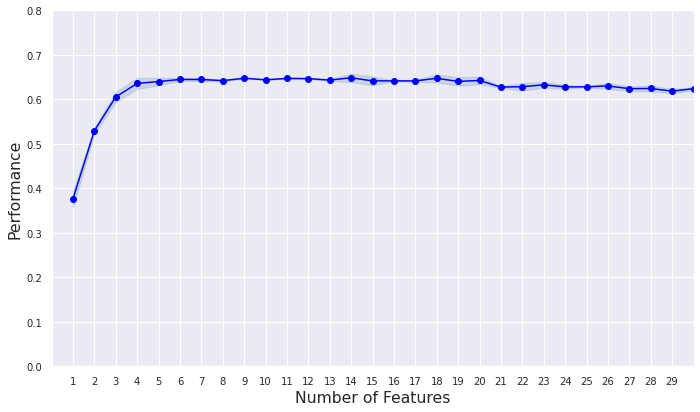

In [33]:
# plot the performance of each round selection
sns.set(font_scale=1.3)
fig=plot_sfs(sfs.get_metric_dict(),kind="std_dev",figsize=(10,6))
plt.xticks(np.arange(0,len(temp.columns)),fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([0,.8])
plt.xlim(0,len(temp.columns))
plt.grid(True)
plt.tight_layout()
plt.savefig("ss.png")

In [36]:
# compile feature name into one list ordered by performances
featureList=[]
for items in vars_F["feature_idx"]:
    for item in items:
        if item not in featureList:
            featureList.append(item)
# get list of top features
fea_num_max=vars_F.avg_score.astype("float").idxmax()
features=temp.columns.to_numpy()[featureList][:fea_num_max+1]


In [37]:
sf = StandardScaler()
sf.fit(X_train.loc[:,features])
X_train_num=sf.transform(X_train.loc[:,features])
X_val_num=sf.transform(X_val.loc[:,features])
X_test_num=sf.transform(X_test.loc[:,features])

We can use profit to select a model if we have the average cost and average revenue of each target. Since it's not the case here, f1 macro score is used to be the model selection criterion.

### Baseline

In [38]:
lr = LogisticRegression(verbose=3,
                        class_weight="balanced")
grid_values={"C":np.arange(0.1,2.1,0.1)}
grid_clf_lr = GridSearchCV(lr, 
                            param_grid = grid_values,
                            scoring = 'f1',
                           cv=3,
                           n_jobs=-1).fit(X_train_num,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [41]:
def f1_gen(model,cutoff=0.5):
    score_list=[]
    y_pred_train=model.predict_proba(X_train_num)[:,1]>=cutoff
    score_list.append(round(f1_score(y_train,y_pred_train),3))
    
    y_pred_val=model.predict_proba(X_val_num)[:,1]>=cutoff
    score_list.append(round(f1_score(y_val,y_pred_val),3))
    return score_list

In [42]:
model_peformance=pd.DataFrame(index=["train","val"])
model_peformance["lr"]=f1_gen(grid_clf_lr)

,lr
train,0.582
val,0.604


### Random Forest

In [44]:
#Random Forest baseline
clf_rf=RandomForestClassifier().fit(X_train_num, y_train)
model_peformance["rf_default"]=f1_gen(clf_rf)

In [45]:
# tune max_features of Random Forest
train_score=[]
test_score=[]
for i in range(1,11):
    clf=RandomForestClassifier(max_features=i,n_jobs=-1).fit(X_train_num,y_train)
    y_train_pred=clf.predict(X_train_num)
    y_test_pred=clf.predict(X_test_num)
    train_score.append(f1_score(y_train,y_train_pred))
    test_score.append(f1_score(y_test,y_test_pred))

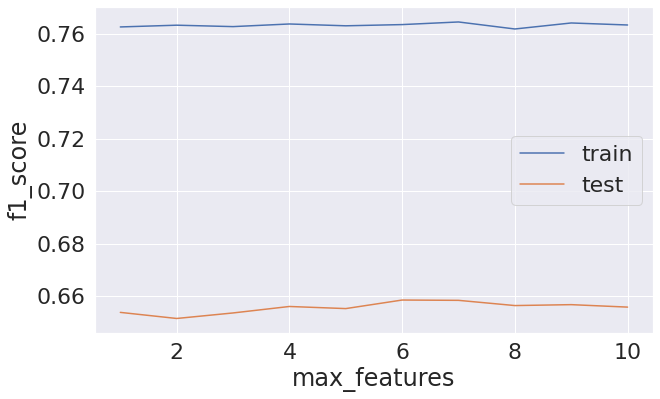

In [46]:
plt.rcParams["figure.figsize"] = [10,6]
sns.set(font_scale=2)
plt.plot(range(1,11),train_score,label="train")
plt.plot(range(1,11),test_score,label="test")
plt.xlabel("max_features")
plt.ylabel("f1_score")
plt.legend()
plt.show()

In [48]:
# tune other hyperparameters with gridsearch
clf=RandomForestClassifier(max_features=max(train_score))
grid_values = {'n_estimators': [20,50,100],
              'max_depth':[1,2,5,10],
              'min_samples_leaf':[1,10,20],
              'criterion':["entropy","gini"]}
grid_clf_rf = GridSearchCV(clf, 
                            param_grid = grid_values,
                            scoring = 'f1',
                           cv=3,
                           n_jobs=-1).fit(X_train_num,y_train)

In [49]:
model_peformance["rf_best"]=f1_gen(grid_clf_rf)

### Gradient Boosting Tree

In [50]:
clf_gdbt=GradientBoostingClassifier().fit(X_train_num, y_train)
model_peformance["gdbt_default"]=f1_gen(clf_gdbt)

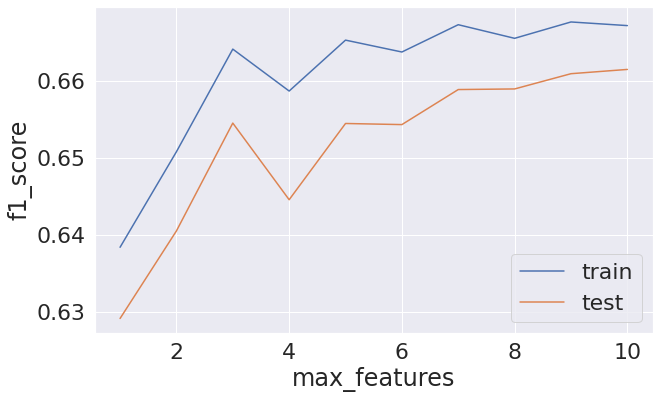

In [51]:
train_score=[]
test_score=[]
for i in range(1,11):
    clf=GradientBoostingClassifier(max_features=i).fit(X_train_num,y_train)
    y_train_pred=clf.predict(X_train_num)
    y_test_pred=clf.predict(X_test_num)
    train_score.append(f1_score(y_train,y_train_pred))
    test_score.append(f1_score(y_test,y_test_pred))
    
plt.rcParams["figure.figsize"] = [10,6]
sns.set(font_scale=2)
plt.plot(range(1,11),train_score,label="train")
plt.plot(range(1,11),test_score,label="test")
plt.xlabel("max_features")
plt.ylabel("f1_score")
plt.legend()
plt.show()

In [52]:
clf=GradientBoostingClassifier(max_features=max(train_score))
grid_values = {'n_estimators': [100,150,200],
              'max_depth':[3,4,5],
              'min_samples_leaf':[1,10,20],
              'learning_rate':[0.01,0.05,0.1],
              'subsample':[0.7,1]}
grid_clf_gdbt = GridSearchCV(clf, 
                            param_grid = grid_values,
                            scoring = 'f1',
                           cv=3,
                           n_jobs=-1).fit(X_train_num,y_train)

In [53]:
model_peformance["gdbt_best"]=f1_gen(grid_clf_gdbt)

### Neural Network

In [54]:
mlp_gs=MLPClassifier(hidden_layer_sizes=(5,),random_state=123).fit(X_train_num,y_train)
model_peformance["nn_default"]=f1_gen(mlp_gs)

In [55]:
clf=MLPClassifier(random_state=123)
grid_values = {'hidden_layer_sizes': [(5,),(10,),(20,),(5,5),(10,10),(20,20)],
              'alpha': [0.0001, 0.05]}
grid_clf_nn = GridSearchCV(clf, 
                            param_grid = grid_values,
                            scoring = 'f1',
                           cv=3,
                           n_jobs=-1).fit(X_train_num,y_train)

In [56]:
model_peformance["nn_best"]=f1_gen(grid_clf_nn)

In [58]:
model_peformance.T

,train,val
lr,0.582,0.604
rf_default,0.764,0.661
rf_best,0.688,0.661
gdbt_default,0.669,0.662
gdbt_best,0.711,0.684
nn_default,0.539,0.565
nn_best,0.674,0.652


Based on f1-macro score, I will use the tuned Random Forest to predict the second round of response

In [60]:
# prediction for the 2nd round responses
response_2nd=grid_clf_gdbt.predict(X_test_num)

Only those predicted to be response will be targted in the 2nd round.

### Marketing performance

#### Original plan for 2nd round

In [61]:
target_orgin=X_test.shape[0]
response_yes_orgin=y_test.sum()
response_no_origin=target_orgin-response_yes_orgin

#### New plan for 2nd round

In [62]:
# target_num_1st=X_train.shape[0]+X_val.shape[0]
target_new=response_2nd.sum()
response_yes_new=sum((response_2nd==1)&(y_test==1))
response_no_new=target_new-response_yes_new

In [63]:
response_num=[response_yes_orgin,response_no_origin,response_yes_new,response_no_new]
response_type=["Yes","No"]*2
plan_type=["Original"]*2+["New"]*2
df_summary=pd.DataFrame(list(zip(response_num,response_type,plan_type)),columns=["response_num","response_type","plan_type"])

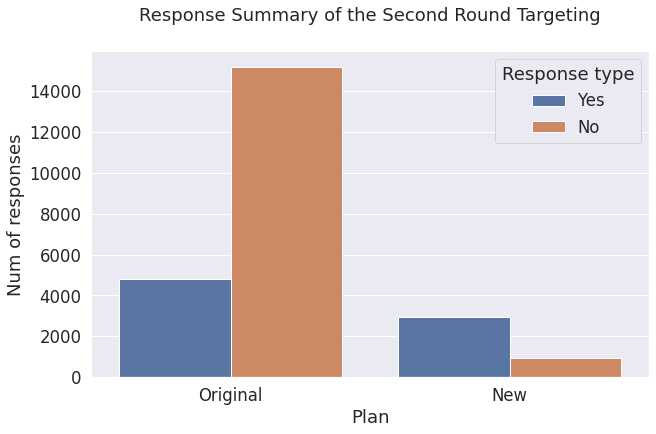

In [64]:
plt.rcParams["figure.figsize"] = [10,6]
sns.set(font_scale=1.5)
plot=sns.barplot(x="plan_type",y="response_num",data=df_summary,ci=None,hue="response_type")
plot.set(xlabel="Plan",ylabel="Num of responses")
plt.title("Response Summary of the Second Round Targeting",pad=30)
plt.legend(title="Response type")
plt.savefig("result.png")

In [65]:
df_summary.to_csv("model_summary.csv")
df_summary

,response_num,response_type,plan_type
0,4813,Yes,Original
1,15187,No,Original
2,2958,Yes,New
3,946,No,New


In [66]:
def perform_eval(df,mr=12,mc=3):
    original_cost=df.query('plan_type=="Original"')["response_num"].sum()*mc
    original_rev=df_summary.query('plan_type=="Original" & response_type=="Yes"')["response_num"].sum()*mr
    original_profit=original_rev-original_cost
    
    new_cost=df.query('plan_type=="New"')["response_num"].sum()*mc
    new_rev=df_summary.query('plan_type=="New" & response_type=="Yes"')["response_num"].sum()*mr
    new_profit=new_rev-new_cost
    
    return(original_profit,new_profit)

In [67]:
perform_eval(df_summary)

(-2244, 23784)

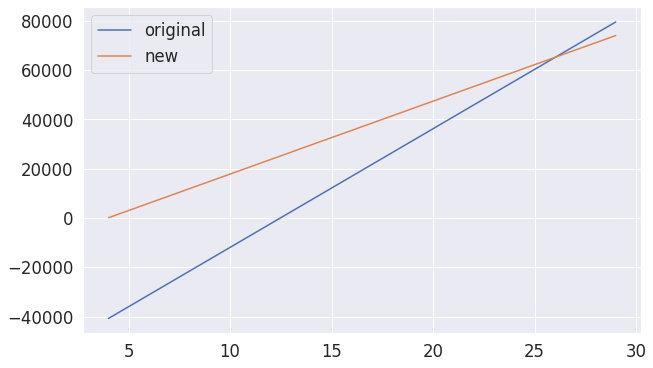

In [78]:
origin_profit=[]
new_profit=[]
for i in range(4,30):
    x,y=perform_eval(df_summary,mr=i)
    origin_profit.append(x)
    new_profit.append(y)

plt.plot(range(4,30),origin_profit,label="original")
plt.plot(range(4,30),new_profit,label="new")
plt.legend();

In [81]:
profit=perform_eval(df_summary)

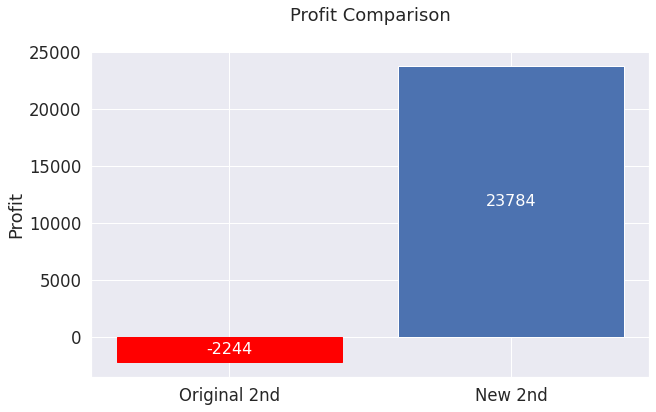

In [144]:
fig,ax=plt.subplots(figsize=(10,6))
ax.bar(["Original 2nd","New 2nd"],profit)
ax.get_children()[0].set_color("red")
plt.ylabel("Profit")
plt.title("Profit Comparison",pad=30)


for i,p in enumerate(plt.gca().patches):
    height=p.get_y()
    ax.text(
        p.get_x()+p.get_width()/2, height+p.get_height()/2,profit[i],ha="center",va="center", color="w", fontsize=16
    )
plt.savefig("profit.png")